In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [3]:
seed = 101
np.random.seed(seed)
tf.random.set_seed(seed)

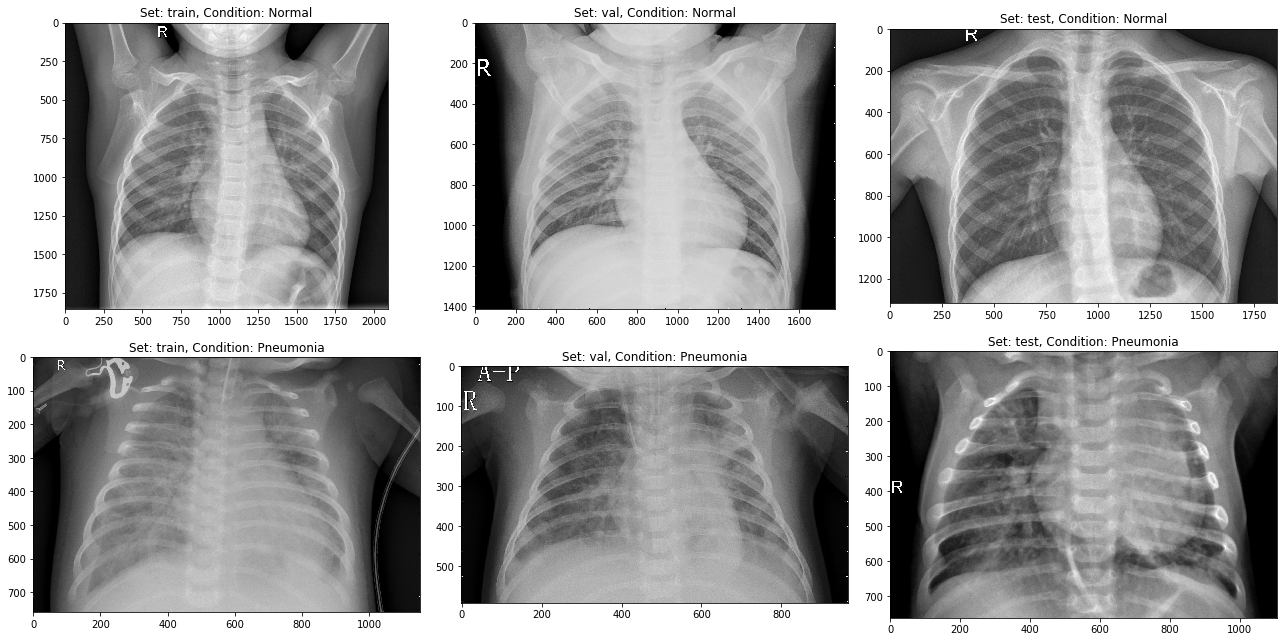

In [4]:
path = 'C:/Users/siddh/Downloads/Projects/My work/Pneumonia/chest_xray/'

fig, ax = plt.subplots(2,3, figsize = (18,9))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = path + _set
    ax[i].imshow(plt.imread(set_path + '/NORMAL/' + os.listdir(set_path + '/NORMAL')[0]), cmap = 'gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA')[0]), cmap = 'gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))


In [5]:
for _set in ['train', 'val', 'test']:
    n_norm = len(os.listdir(path + _set + '/NORMAL'))
    n_infected = len(os.listdir(path + _set + '/NORMAL'))
    print('Set: {}, normal imagaes: {}, infected images: {}'.format(_set, n_norm, n_infected))

Set: train, normal imagaes: 1341, infected images: 1341
Set: val, normal imagaes: 8, infected images: 8
Set: test, normal imagaes: 234, infected images: 234


In [6]:
def process_data(img_dim, batch_size):
    
    train_img_datagen = ImageDataGenerator(zoom_range = 0.3, rescale = 1./255, vertical_flip = True)
    test_val_img_datagen = ImageDataGenerator(zoom_range= 0.3, rescale = 1./255, vertical_flip = True)
    
    train_gen = train_img_datagen.flow_from_directory(
    directory = path + 'train',
    target_size = (img_dim, img_dim),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
    )
    
    test_gen = test_val_img_datagen.flow_from_directory(
    directory = path + 'test',
    batch_size = batch_size,
    target_size = (img_dim, img_dim),
    class_mode = 'binary',
    shuffle = True
    )
    
    test_data = []
    test_label = []
    
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path + 'test' + cond)):
            img = plt.imread(path + 'test' + cond + img)
            img = cv2.resize(img, (img_dim, img_dim))
            img = np.dstack([img, img, img])
            img = img.astype('float32')/255
            
            if cond == '/NORMAL/':
                label =0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_label.append(label)
    
    test_data = np.array(test_data)
    test_label = np.array(test_label)
    
    return train_gen, test_gen, test_data, test_label


In [7]:
img_dim = 150
epochs = 25
batch_size = 32
train_gen, test_gen, test_data, test_labels = process_data(img_dim, batch_size)

validation_split = 0.2
verbosity = 1

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:


base_model = Sequential()
  
# This is the first convolution
base_model.add(Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)))
base_model.add(MaxPool2D(2, 2))
  
# The second convolution
base_model.add(Conv2D(32, (3,3), activation='relu'))
base_model.add(MaxPool2D(2,2))
  
# The third convolution
base_model.add(Conv2D(64, (3,3), activation='relu'))
base_model.add(MaxPool2D(2,2))
  
# The fourth convolution
base_model.add(Conv2D(64, (3,3), activation='relu'))
base_model.add(MaxPool2D(2,2))

# The fifth convolution
base_model.add(Conv2D(64, (3,3), activation='relu'))
base_model.add(MaxPool2D(2,2))

#fully connected dense layer
base_model.add(Flatten())
base_model.add(Dense(units=512, activation='relu'))
base_model.add(Dropout(rate=0.7))
base_model.add(Dense(units=128, activation='relu'))
base_model.add(Dropout(rate=0.5))
base_model.add(Dense(units=64, activation='relu'))
base_model.add(Dropout(rate=0.3))
               
# Output layer
base_model.add(Dense(units=1, activation='sigmoid'))

# Creating model and compiling
base_model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
base_model.summary()          
                         
               
               
               


# # to get the summary of the model
# model.summary()

# # configure the model for traning by adding metrics
# model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)       

In [18]:
# Using fit_generator() instead of fit() because we are going to use data taken from the generator. Note that the randomness is changing
# on each epoch
hist = base_model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size)

Epoch 1/25
163/163 [==============================] - 128s 786ms/step - loss: 0.5916 - accuracy: 0.7366 - val_loss: 0.6705 - val_accuracy: 0.6250
Epoch 2/25
163/163 [==============================] - 127s 778ms/step - loss: 0.5770 - accuracy: 0.7429 - val_loss: 0.6734 - val_accuracy: 0.6299
Epoch 3/25
163/163 [==============================] - 124s 762ms/step - loss: 0.5421 - accuracy: 0.7437 - val_loss: 0.6004 - val_accuracy: 0.6546
Epoch 4/25
163/163 [==============================] - 119s 733ms/step - loss: 0.3912 - accuracy: 0.8115 - val_loss: 0.7380 - val_accuracy: 0.7188
Epoch 5/25
163/163 [==============================] - 118s 723ms/step - loss: 0.3584 - accuracy: 0.8374 - val_loss: 0.6034 - val_accuracy: 0.7500
Epoch 6/25
163/163 [==============================] - 119s 730ms/step - loss: 0.3436 - accuracy: 0.8443 - val_loss: 0.5048 - val_accuracy: 0.8010
Epoch 7/25
163/163 [==============================] - 120s 738ms/step - loss: 0.3067 - accuracy: 0.8658 - val_loss: 0.4573 -

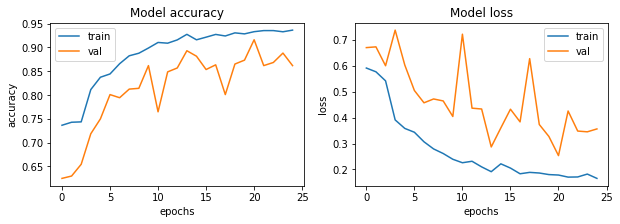

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix

pred = base_model.predict(test_data)

acc = accuracy_score(test_labels, np.round(pred))*100
cm = confusion_matrix(test_labels, np.round(pred))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[187  47]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 91.50641025641025%
Precision: 89.0951276102088%
Recall: 98.46153846153847%
F1-score: 93.54445797807551

TRAIN METRIC ----------------------
Train acc: 93.63


In [22]:
inputs = Input(shape=(img_dim, img_dim, 3))

# First conv block
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [23]:
hist1 = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/25
163/163 [==============================] - 411s 3s/step - loss: 0.3862 - accuracy: 0.8207 - val_loss: 0.6629 - val_accuracy: 0.6234
Epoch 2/25
163/163 [==============================] - 401s 2s/step - loss: 0.2757 - accuracy: 0.8854 - val_loss: 0.6580 - val_accuracy: 0.6266
Epoch 3/25
163/163 [==============================] - 381s 2s/step - loss: 0.2451 - accuracy: 0.9032 - val_loss: 1.1096 - val_accuracy: 0.6266
Epoch 4/25
163/163 [==============================] - 376s 2s/step - loss: 0.2519 - accuracy: 0.8988 - val_loss: 2.4893 - val_accuracy: 0.6316
Epoch 5/25
163/163 [==============================] - 375s 2s/step - loss: 0.2052 - accuracy: 0.9266 - val_loss: 1.1196 - val_accuracy: 0.6875
Epoch 6/25
163/163 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9172
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 377s 2s/step - loss: 0.2211 - accuracy: 0.9172 - val_loss: 0.3639 

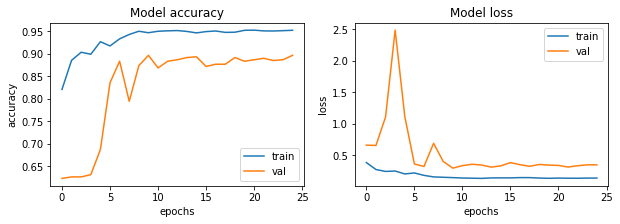

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist1.history[met])
    ax[i].plot(hist1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist1.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[191  43]
 [  9 381]]

TEST METRICS ----------------------
Accuracy: 91.66666666666666%
Precision: 89.85849056603774%
Recall: 97.6923076923077%
F1-score: 93.61179361179362

TRAIN METRIC ----------------------
Train acc: 95.19
